# Machine Learning Introduction

## Machine Learning Modeling in Python with scikit-learn Pipelines

### Michael Pyrcz, Associate Professor, University of Texas at Austin

### Machine Learning Modeling Pipelines

Machine learning modeling can be complicated with various steps:
* data preparation, feature engineering transformations
* model parameter fitting
* modeling method selection
* searching over a large combinatorial of hyperparameters
* training and testing model runs

Pipeline is a scikit-learn class that allows for encapsilation of a sequence of data preparation and modeling steps
* then we can treat pipeline as an object in our much condensed workflow

The pipeline class allows us to:
* improve code readability and to keep everything straight
* avoid common workflow problems like data leakage, testing data informing model parameter training
* abstract common machine learning modeling and focus on building the best model possible

The fundamental philosophy is to treat machine learning as a combinatorial search to find the best model (AutoML)

**Machine learning-based Prediction**
Predictive machine learning methods with supervised learning

 **Prediction**
 * non-parametric method for regression and classification
 * a function $\hat{f}$ of the nearest $k$ training data in predictor feature space such as we predict a response feature $Y$ from a set of predictor features $X_1, \dots, X_m$ 
 * the prediction is of the form $\hat{Y} = \hat{f}(X_1, \dots, X_m)$
 
 **Supervised learning**
 * the response feature label $Y$, is available over the training and testing data.

**The Machine Learning Models**

This workflow include these models:
* linear regression
* k-nearest neighbor regression
* decision tree regression
* random forest regression
* tree-based gradient boosting regression

**Input Required Libraries**

In [1]:
import os
import math
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree, metrics
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
import pandas.plotting as pd_plot
import matplotlib.pyplot as plt
from subprocess import check_call
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
seed = 73073

**Declare function**

Let's define a couple of functions to streamline plotting correlation matrices and visualization of a decision tree regression model.

In [2]:
def visualize_model(model,xfeature,x_min,x_max,x_label,yfeature,y_min,y_max,y_label,
                     response,z_min,z_max,resp_label, title, legend=True):
    n_classes = 10
    cmap = plt.cm.RdYlBu
    plot_step = 0.02
    xx, yy = np.meshgrid(np.arange(x_min,x_max,plot_step),np.arange(y_min,y_max,plot_step))
    Z = model.predict(np.c_[xx.ravel(),yy.ravel()])
    Z = np.clip(Z,z_min,z_max)
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, vmin=z_min,vmax=z_max,levels=np.linspace(z_min,z_max,100))
    
    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None,
                     vmin=z_min, vmax=z_max, alpha = 0.8, linewidths=0.3, edgecolor='k')
    plt.title(title)
    plt.xlabel(x_label); plt.ylabel(y_label)
    plt.xlim(x_min,x_max); plt.ylim(y_min,y_max)
    if legend == True:
        cbar = plt.colorbar(im, orientation='vertical')
        cbar.set_label(resp_label, rotation =270, labelpad=20)
    


In [3]:
def visualize_model_sub(ax,model,xfeature,x_min,x_max,yfeature,y_min,y_max,
                        response,z_min,z_max,title,legend=True):
    n_classes = 10
    cmap = plt.cm.RdYlBu
    plot_step = 0.02
    xx, yy = np.meshgrid(np.arange(x_min,x_max,plot_step),np.arange(y_min,y_max,plot_step))
    Z = model.predict(np.c_[xx.ravel(),yy.ravel()])
    Z = np.clip(Z,z_min,z_max)
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, cmap=cmap, vmin=z_min, vmax=z_max, levels=np.linspace(z_min, z_max, 100))

    im = ax.scatter(xfeature, yfeature, s=None, c=response, marker=None, cmap=cmap,
                    norm=None,vmin=z_min, vmax=z_max,alpha=0.8,linewidths=0.3,edgecolor='k')
    ax.set_title(title); ax.set_xlabel(xfeature.name); ax.set_ylabel(yfeature.name)
    ax.set_xlim(x_min,x_max)
    ax.set_ylim(y_min,y_max)
    if legend==True:
        cbar = plt.colorbar(im, orientation='vertical')
        cbar.set_label(response.name, rotation=270,labelpad=20)

In [4]:
def visualize_model_wrap(model,ix1,ix2,iy,title,trans=True):
    if trans==True:
        visualize_model(model,X[features[ix1]],vmin_trans[ix1],vmax_trans[ix1],str(features[ix1])+' (' + str(units[ix1]) + ') ',
                        X[features[ix2]],vmin_trans[ix2],vmax_trans[ix2],str(features[ix2])+' (' + str(units[ix2]) + ') ',
                        y[features[iy]],vmin[iy],vmax[iy],str(features[iy])+ ' (' + str(units[iy]) + ') ',
                        title, legend=True)   # plots the data points and the decision tree prediction
    if trans==False:
        visualize_model(model,X_orig[features[ix1]],vmin_trans[ix1],vmax_trans[ix1],str(features[ix1])+' (' + str(units[ix1]) + ') ',
                        X_orig[features[ix2]],vmin_trans[ix2],vmax_trans[ix2],str(features[ix2])+' (' + str(units[ix2]) + ') ',
                        y[features[iy]],vmin[iy],vmax[iy],str(features[iy])+ ' (' + str(units[iy]) + ') ',
                        title, legend=True)   # plots the data points and the decision tree prediction
        

In [5]:
def visualize_tuned_model(k_tuned, k_mat, score_mat):
    plt.scatter(k_mat, score_mat, s=5.0, c='red', marker=None, norm=None, cmap=None, vmin=None, vmax=None,
                alpha=0.2, linewidth=0.5,  ec='k')
    plt.plot([k_tuned,k_tuned], [0,10000000], color='black', linestyle=(6,(2,3)), label='tuned',  zorder=1)
    plt.title('k-fold Cross Validation Erros (MSE) vs. k-Nearest Neighbors')
    plt.xlabel('Number of Nearest Neighbors')
    plt.ylabel('Mean Squared Error')
    plt.xlim(k_min, k_max)
    plt.ylim(0, np.max(score_mat))

In [6]:
def visualize_tuned_model2(k_tuned,k_mat,score_mat):
    plt.scatter(k_mat[0:len(k_mat):2], score_mat[0:len(k_mat):2], s=5.0, c='red', marker=None, norm=None, cmap=None, vmin=None, vmax=None,
                alpha=0.4, linewidth=0.5, ec='k', label='uniform',zorder=3)
    plt.scatter(k_mat[1:len(k_mat):2], score_mat[1:len(k_mat):2], s=5.0, c='blue', marker=None, norm=None, cmap=None, vmin=None, vmax=None,
                alpha=0.4, linewidth=0.5, ec='k', label='distance',zorder=2)    
    plt.plot([k_tuned,k_tuned], [0,10000000], color='black', linestyle=(6,(2,3)), label='tuned',  zorder=1)
    plt.title('k-fold Cross Validation Error (MSE) vs. k-Nearest Neighbors')
    plt.xlabel('Number of Nearest Neighbors')
    plt.ylabel('Mean Squared Error')
    plt.legend(loc='lower right')
    plt.xlim(k_min, k_max)
    plt.ylim(0, np.max(score_mat))    

### Read the data table

In [7]:
df = pd.read_csv("https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV.csv")
df.head()

,WellIndex,Por,LogPerm,AI,Brittle,TOC,VR,Production
0,1,15.91,1.67,3.06,14.05,1.36,1.85,177.381958
1,2,15.34,1.65,2.60,31.88,1.37,1.79,1479.767778
2,3,20.45,2.02,3.13,63.67,1.79,2.53,4421.221583
3,4,11.95,1.14,3.90,58.81,0.40,2.03,1488.317629
4,5,19.53,1.83,2.57,43.75,1.40,2.11,5261.094919


In [8]:
df = df.iloc[:,1:8]
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Por,1000.0,14.950460,3.029634,5.400000,12.85750,14.98500,17.080000,24.65000
LogPerm,1000.0,1.398880,0.405966,0.120000,1.13000,1.39000,1.680000,2.58000
AI,1000.0,2.982610,0.577629,0.960000,2.57750,3.01000,3.360000,4.70000
Brittle,1000.0,49.719480,15.077006,-10.500000,39.72250,49.68000,59.170000,93.47000
TOC,1000.0,1.003810,0.504978,-0.260000,0.64000,0.99500,1.360000,2.71000
VR,1000.0,1.991170,0.308194,0.900000,1.81000,2.00000,2.172500,2.90000
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413


It is good that we checked the summary statistics, because we have some negative values for brittleness and total organic carbon. There is physically impossible. The values must be in error. We know the lowest possible values are 0.0, so we will truncate on 0.0. We use the `_get_numeric_data()` DataFrame member function to get shallow copy of the data from the DataFrame. Since it is a shallow copy, any changes we make to the copy are made to the data in the original DataFrame. This allows us to apply this simple conditional statement to all the data values in DataFrame all at oncce.

In [9]:
num = df._get_numeric_data()
num[num < 0] = 0
num.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Por,1000.0,14.950460,3.029634,5.400000,12.85750,14.98500,17.080000,24.65000
LogPerm,1000.0,1.398880,0.405966,0.120000,1.13000,1.39000,1.680000,2.58000
AI,1000.0,2.982610,0.577629,0.960000,2.57750,3.01000,3.360000,4.70000
Brittle,1000.0,49.731480,15.033593,0.000000,39.72250,49.68000,59.170000,93.47000
TOC,1000.0,1.006170,0.499838,0.000000,0.64000,0.99500,1.360000,2.71000
VR,1000.0,1.991170,0.308194,0.900000,1.81000,2.00000,2.172500,2.90000
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413


**Let's build a predictive Machine Learning Model**

We will complete the entire data transformation, model parameter training and model hyperparameter tuning workflow:
1. step-by-step with low level code
2. with a concise high-level code using **pipelines**

Here's our machine learning prediction model
$$y = f(X_1, X_2) + \epsilon$$

We will use k-nearest neighbors regression

**The general workflow is:**
A. **Data Preparation and Feature Engineering** - visualize the data, store feature labels and units, select 2 predictor features and standardized the predictor features to avoid biased predictions due to difference in units. We can also add noise to the response feature to better observe model overfit.

B. Select 2 features so we can visualize the model

Note, we select 2 features for ease of model visualizaion and to provide the opportunity to explore different models with the same dataset.

**A. Data Preparation and Feature Engineering**

The k-nearest neighbors, etc. method uses a nearest training sample search in feature space (like k-means clustering). To remove the impact feature range from the approach we standaedize the feature.
* we will standardize our predictor features to have a mean of zero and a variance of one.
* we use the scikit learn preprocessing to simplify this step and to provide a reverse transform.

We will also store the name, units, minimum and maximum values in arrays.

In [10]:
transform = StandardScaler()
data = df.copy(deep=True)
data.iloc[:,:] = transform.fit_transform(df)
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Por,1000.0,1.332268e-16,1.0005,-3.153925,-0.691175,0.011406,0.703255,3.203157
LogPerm,1000.0,-3.135270e-16,1.0005,-3.151793,-0.662653,-0.021885,0.692819,2.910864
AI,1000.0,4.067857e-16,1.0005,-3.503327,-0.701684,0.047442,0.653670,2.974660
Brittle,1000.0,1.705303e-16,1.0005,-3.309679,-0.666107,-0.003426,0.628143,2.910842
TOC,1000.0,-5.329071e-18,1.0005,-2.014001,-0.732944,-0.022358,0.708244,3.410473
VR,1000.0,-3.907985e-16,1.0005,-3.542302,-0.588138,0.028665,0.588658,2.950365
Production,1000.0,2.415845e-16,1.0005,-1.533683,-0.721496,-0.185038,0.530431,7.052394


**Feature Attributes**
* name
* units
* minimum value
* maximum value

To assit with all the plots and associated labels and color bars.

In [11]:
features = np.array(data.columns.tolist())  # array of feature names
units = ['%', 'Log(mD)','kg/m2s*10^6','%','%','%','MCFPD']  # list of feature units
# list of feature minimums and maximums
vmin = df.min()
vmax = df.max()
# list of feature minimums and maximums
vmin_trans = data.min()
vmax_trans = data.max()

print("Available features are " + str(features) + '.')
print("Available features\' units are " + str(units) + '.')
print("Available features\' minimum values are " + str(vmin.values) + '.')
print("Available features\' maximum values are " + str(vmax.values) + '.')
print("Available transformed features\' minimum values are " + str(vmin_trans.values) + '.')
print("Available transformed features\' maximum values are " + str(vmax_trans.values) + '.')

Available features are ['Por' 'LogPerm' 'AI' 'Brittle' 'TOC' 'VR' 'Production'].
Available features' units are ['%', 'Log(mD)', 'kg/m2s*10^6', '%', '%', '%', 'MCFPD'].
Available features' minimum values are [5.4        0.12       0.96       0.         0.         0.9
 2.71353485].
Available features' maximum values are [2.46500000e+01 2.58000000e+00 4.70000000e+00 9.34700000e+01
 2.71000000e+00 2.90000000e+00 1.25686441e+04].
Available transformed features' minimum values are [-3.15392477 -3.15179313 -3.50332658 -3.30967893 -2.0140009  -3.54230176
 -1.53368327].
Available transformed features' maximum values are [3.20315665 2.91086412 2.97466048 2.91084154 3.41047254 2.95036531
 7.0523943 ].


This dataset has variables from 1,000 unconventional wells including well average porosity, log transform of permeability (to linearize the relationships with other variables), acoustic impedance $(kg/m2s*10^6)$, brittness ratio (%), total organic carbon (%), vitrinite reflectance (%), and initial production 90 day average (MCFDP). The dataset is synthetic. 

**Working with only two Predictor Features**
Let's simplify the problem:
* to predict 2 features, Porosity and Brittness to predict Production rate. 
* this is very easy to visualize the prediction model as a map over the predictor feature space.

Select 2 predictor features and the 1 response feature by indexbelow with this code:
\begin{align*}
&ix1 = 0 \\
&ix2 = 3 \\
&iy = 6 \\
\end{align*}
Make sure the index is between 0 and do not repeat

In [12]:
# select the predictor feature
ix1 = 0
ix2 = 3
# select the response feature
iy = 6
# use transformed predictor features
X = data.iloc[:,[ix1,ix2]]
# include nontransformed predictor features for pipeline
X_orig = df.iloc[:,[ix1,ix2]]
# use the original response feature
y = pd.DataFrame(data = df.iloc[:,iy])
print('Predictor features are ' + str(features[[ix1,ix2]]) + ' and the response feature is ' + str(features[iy]) +'.')

Predictor features are ['Por' 'Brittle'] and the response feature is Production.


**Add random error to the Response Feature, $y$**

This dataset is quite well-behaved and error free.
* to observe issues of overfit in model training, let's add some error.

In [13]:
standardized_error_standardized_deviation = 1000.0
y_old = y.copy(deep=True)
y[features[iy]] = y[features[iy]] + np.random.normal(loc = 0, scale = standardized_error_standardized_deviation,
                                                     size = y.shape[0])


 **Data Univariate Distributions**
 
 Let's first check the univariate statistics of 2 predictor features $x_1$ and $X_2$ and response feature $y$

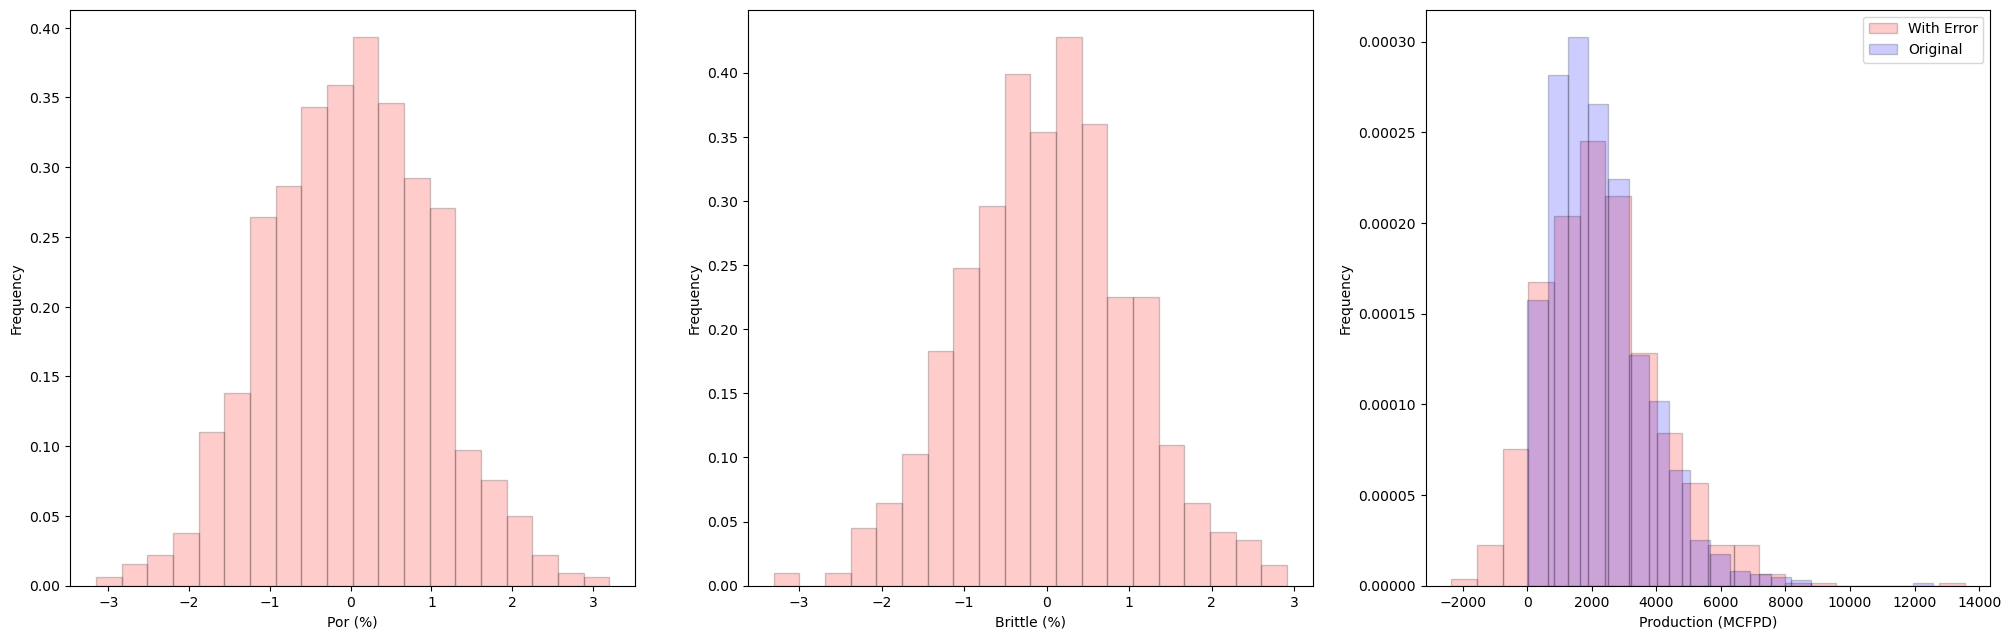

In [14]:
plt.subplot(131)
plt.hist(X[features[ix1]], alpha = 0.2, color='red', ec='k', bins=20, density= True)
plt.xlabel(str(features[ix1]) + ' (' + str(units[ix1]) + ')' )
plt.ylabel('Frequency')

plt.subplot(132)
plt.hist(X[features[ix2]], alpha = 0.2, color='red', ec='k', bins=20, density= True)
plt.xlabel(str(features[ix2]) + ' (' + str(units[ix2]) + ')' )
plt.ylabel('Frequency')

plt.subplot(133)
plt.hist(y, alpha = 0.2, color='red', ec='k', bins=20, density= True, label='With Error')
plt.hist(y_old, alpha = 0.2, color='blue', ec='k', bins=20, density= True, label='Original')
plt.xlabel(str(features[iy]) + ' (' + str(units[iy]) + ')' )
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

**Bivariate Distributions**

The distribution is well-behaved, we cannot observe obvious gaps nor truncations. Let's look at scatter plot of $X_1$ and $X_2$ with point colored by $y$

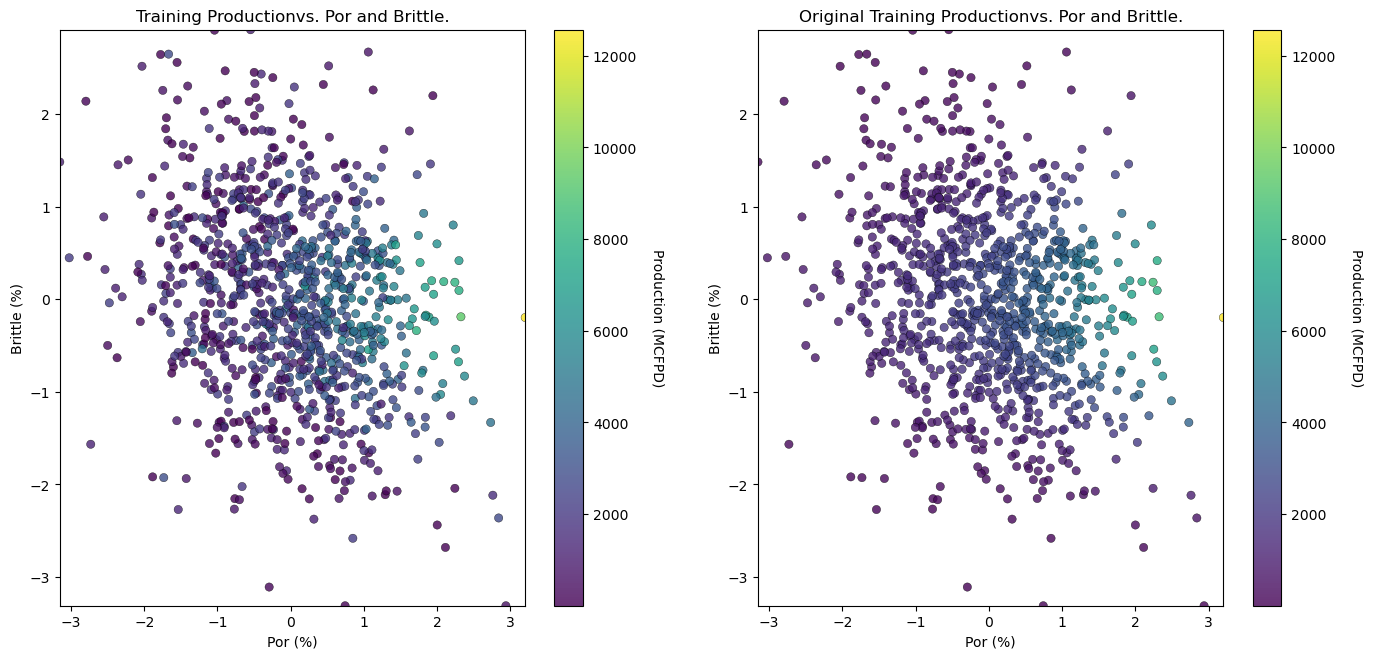

In [15]:
plt.subplot(121)
im = plt.scatter(X[features[ix1]], X[features[ix2]], s=None, c=y[features[iy]], marker=None, cmap=None,
                norm=None, vmin=vmin[iy], vmax=vmax[iy], alpha=0.8, linewidths=0.3, ec='k')
plt.title('Training ' + str(features[iy]) + 'vs. ' + str(features[ix1]) + ' and ' + str(features[ix2]) + '.')
plt.xlabel(str(features[ix1]) +  ' (' + str(units[ix1]) +')')
plt.ylabel(str(features[ix2]) +  ' (' + str(units[ix2]) +')')
plt.xlim(vmin_trans[ix1], vmax_trans[ix1])
plt.ylim(vmin_trans[ix2], vmax_trans[ix2])
cbar = plt.colorbar(im, orientation='vertical')
cbar.set_label(str(features[iy]) + ' (' + str(units[iy]) + ')', rotation=270, labelpad=20)

plt.subplot(122)
im = plt.scatter(X[features[ix1]], X[features[ix2]], s=None, c=y_old[features[iy]], marker=None, cmap=None,
                norm=None, vmin=vmin[iy], vmax=vmax[iy], alpha=0.8, linewidths=0.3, ec='k')
plt.title('Original Training ' + str(features[iy]) + 'vs. ' + str(features[ix1]) + ' and ' + str(features[ix2]) + '.')
plt.xlabel(str(features[ix1]) +  ' (' + str(units[ix1]) +')')
plt.ylabel(str(features[ix2]) +  ' (' + str(units[ix2]) +')')
plt.xlim(vmin_trans[ix1], vmax_trans[ix1])
plt.ylim(vmin_trans[ix2], vmax_trans[ix2])
cbar = plt.colorbar(im, orientation='vertical')
cbar.set_label(str(features[iy]) + ' (' + str(units[iy]) + ')', rotation=270, labelpad=20)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

This problem looks complicated and could not be modeled with simple linear regression. It appears there is a sweet spot for Brittleness and increasing Porosity is always benificial for Production.

**Instantiate, Tune and then predict $k$-Nearest Neighnours**

Let's instantiate, fit and predict with a $k$-nearest neighbour model
* loop over the hyperparameter, $k = k_{min}, \dots, k_{max}$
 * apply k-fold cross validation 
 * calculate the average error over k-folds
* plot the error vs. the $k$ hyperparameter
* select the minimum error $k$ in $k$-fold cross validation
* rebuid the model, training with all data and the tuned $k$ hyperparameter

Recall that $k$ hyperparameter
* $k$ - number of nearest training pdata to use for estimate
* low $k$ - high model complexity/ flexibility
* high $k$ - low model complexity/flexibility

To change the range of considered $k$ hyperparmaeter adjust the following code

\begin{align*}
&k_{min} = 2 \\
&k_{max} = 500
\end{align*}

C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


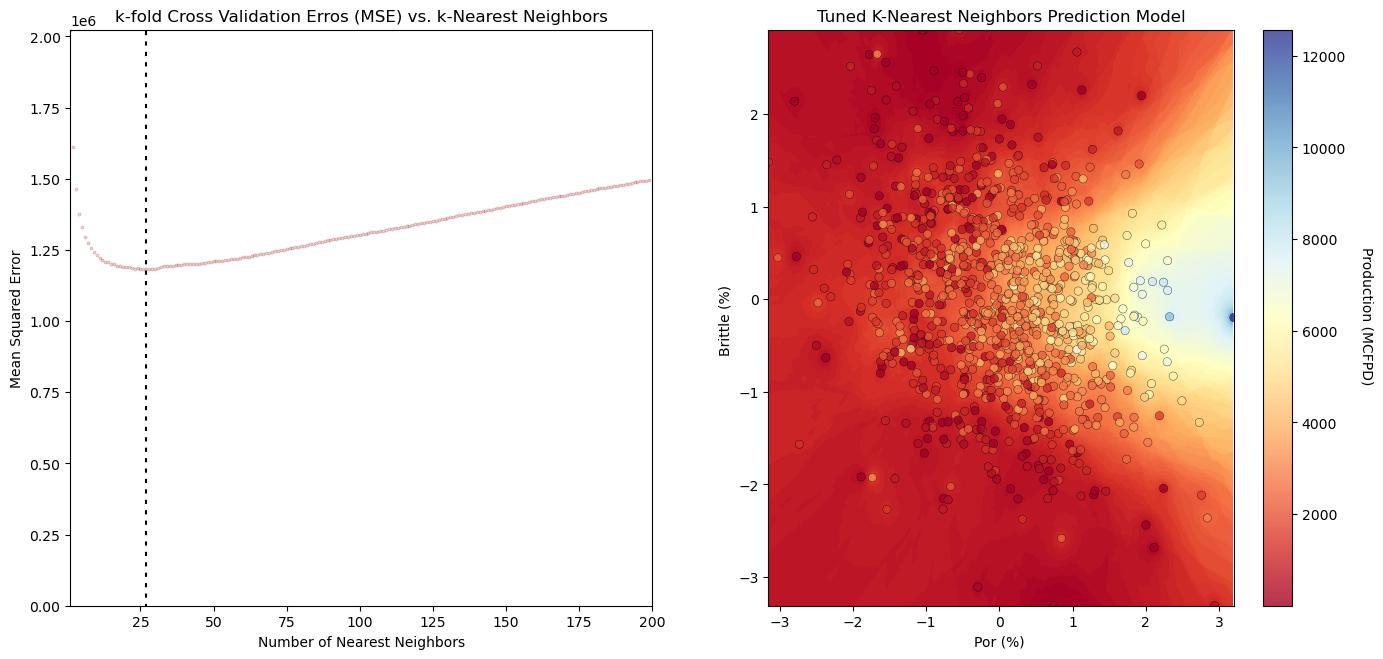

In [16]:
folds = 4     # number of folds for k-fold cross validation
k_min = 1
k_max = 200
#k_max = int(len(my_data)*(folds-1)/(folds)     # use this to select maximum k as possible
np.random.seed(seed=seed)

k_mat = []
score_mat = []
for k in range(k_min, k_max):     # loop over k hyperparameters
    neigh_dist = KNeighborsRegressor(weights='distance', metric='euclidean', n_neighbors=k, p=2) # instantiate the model
    scores = cross_val_score(estimator=neigh_dist, X=X, y=y,
                            cv=KFold(n_splits=folds, shuffle=False),
                            n_jobs=4, scoring='neg_mean_squared_error')
    # store k and average fold error
    k_mat.append(k)
    score_mat.append(abs(np.average(scores))) 
    
min_error, index_tuned = min((error, index) for (index, error) in enumerate(score_mat))   # find the best k
k_tuned = k_mat[index_tuned]

plt.subplot(121)
visualize_tuned_model(k_tuned, k_mat, score_mat)   # visualize error vs. k

neigh_dist_tuned = KNeighborsRegressor(weights='distance', n_neighbors=k_tuned, p=2) # refit tuned model
neigh_dist_tuned.fit(X,y)

plt.subplot(122)
visualize_model_wrap(neigh_dist_tuned,ix1,ix2,iy,'Tuned K-Nearest Neighbors Prediction Model', trans=True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

**Same Complete Workflow with Pipelines**

Let's repeat the above workflow with a pipeline from scikit-learn. Here are some general comments:
* **pipeline workflow steps** - list of steps, custom labels and the associated scikit-learn class.
* **choices and hyperparameters** - as a dictionary with combined step custom labels and hyperparameter names.
* **workflow scenarios** - we can specify list of choices and hyperparameters.
* **consistent iteration** - the entire workflow is repeated for the full combinatorial.
* **best model selected** - best combination of model hyperparamters and choices are refit with all data.

C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


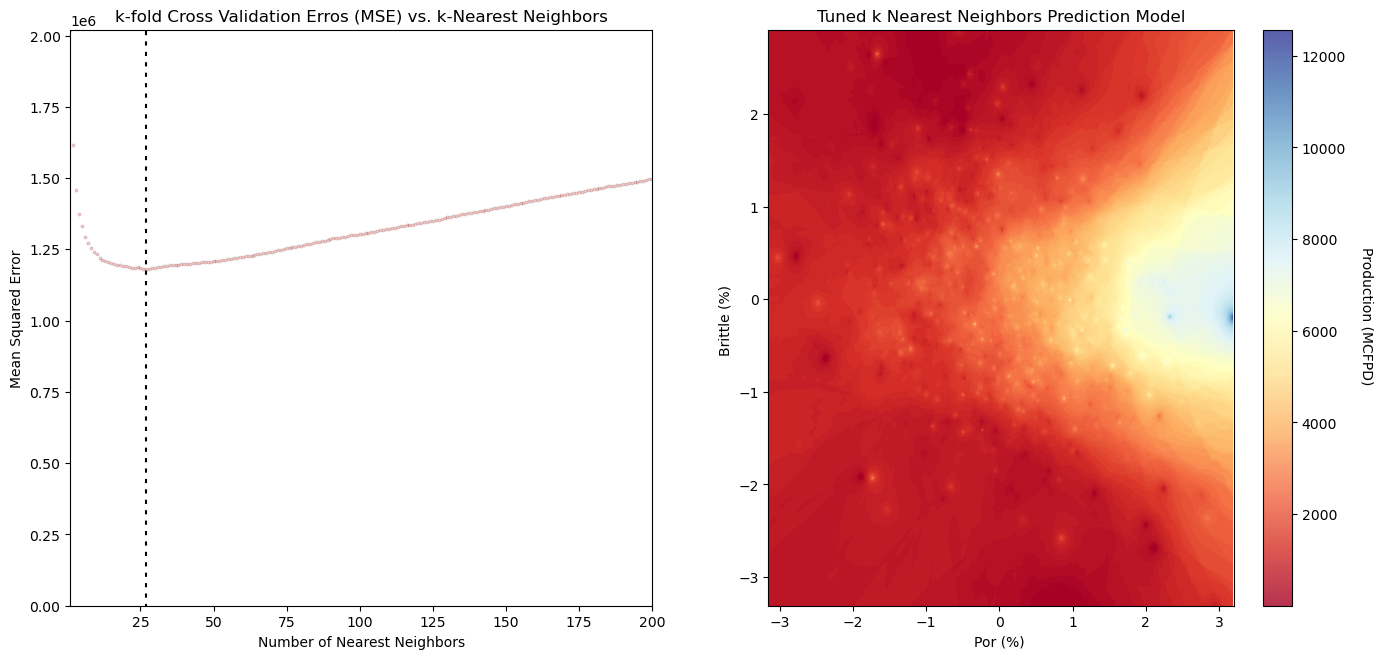

In [17]:
pipe = Pipeline([                                 # the machine learning workflow as pipeline object
    ('scaler', StandardScaler()),
    ('knear', KNeighborsRegressor())
])

params = {
    'scaler': [StandardScaler()],
    'knear__n_neighbors': np.arange(k_min, k_max+1, 1, dtype=int),
    'knear__metric': ['euclidean'],
    'knear__p': [2],
    'knear__weights': ['distance']
}

grid_cv_tuned = GridSearchCV(pipe, params, scoring='neg_mean_squared_error',    # grid search cross validation
                            cv = KFold(n_splits=folds, shuffle=False),
                            refit=True)

grid_cv_tuned.fit(X,y)  # fit model with tuned hyperparameters

plt.subplot(121)
visualize_tuned_model(grid_cv_tuned.best_params_['knear__n_neighbors'],
                     grid_cv_tuned.cv_results_['param_knear__n_neighbors'],
                     abs(grid_cv_tuned.cv_results_['mean_test_score']))

plt.subplot(122)
visualize_model_wrap(grid_cv_tuned, ix1,ix2,iy,'Tuned k Nearest Neighbors Prediction Model', trans=False)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2);
plt.show()

**Discussion**

Let's compare and constrast the without pipeline and with pipeline workflows
**Code Readability - With Pipeline**, this is a great advantage for the pipeline workflow. The list of machine learning steps are included in the pipe instantiation and then the model choices and hyperparameter are listed.

**Book keeping - With pipeline**, the pipeline makes this effortless
 * `.fit()` operator conduct cross validation runs over all hyperparameters after the data transformation(s) and then the best model is refit with all the data.
 * `.predict()` operator encapsulates the data transformations and prediction with the best, refit model. 
 * `best_params_` stores the best model hyperparameter and choices.
 
**Experimentation - with Pipeline**, the pipeline workflows make this extremely compact. We can run any variety of model scenerio and select the best model.

**Control - without pipeline**, there is a lot of flexibility with the current pipeline class, but we may be challenged for highly custom workflows and methods not use the pipeline workflow.

**Retrieve the Tuned Model Hyperparameters**

We can access the best model hyperparameters and choices via `best_params_`

In [18]:
print('The best model hyperparameters:')
grid_cv_tuned.best_params_

The best model hyperparameters:


{'knear__metric': 'euclidean',
 'knear__n_neighbors': 27,
 'knear__p': 2,
 'knear__weights': 'distance',
 'scaler': StandardScaler()}

**More Complicate Model Tuning with Pipelines**

Let's expand the code with pipeline workflow and demonstrate more experimentation
* Let's iterate over more model hyperparameters and choices by including uniform and distance weights.
* We find best combination of hyperparameters to minimizes error in $k$-fold cross validation

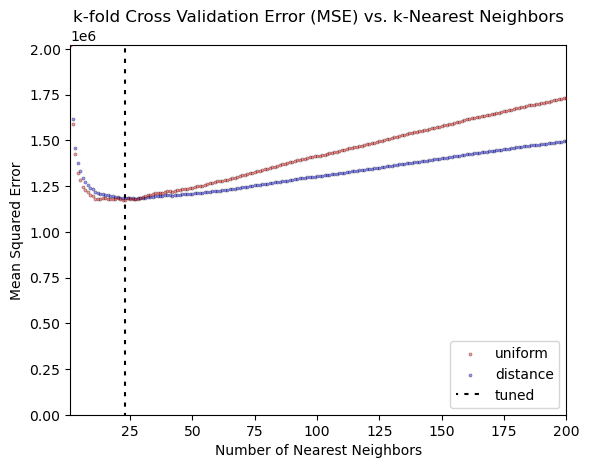

In [19]:
params = {
    'scaler': [StandardScaler()],
    'knear__n_neighbors': np.arange(k_min, k_max+1, 1,dtype=int),
    'knear__metric': ['euclidean'],
    'knear__p': [2],
    'knear__weights': ['uniform','distance']
}

grid_cv_tuned = GridSearchCV(pipe, params, scoring='neg_mean_squared_error',
                            cv=KFold(n_splits=folds, shuffle=False),
                            refit=True)
grid_cv_tuned.fit(X_orig,y)

plt.subplot(111)
visualize_tuned_model2(grid_cv_tuned.best_params_['knear__n_neighbors'],
                      grid_cv_tuned.cv_results_['param_knear__n_neighbors'],
                      abs(grid_cv_tuned.cv_results_['mean_test_score']))

**Retrieve the Tuned Model Hyperparameters**

In [20]:
print('The best model hyperparameters:')
grid_cv_tuned.best_params_

The best model hyperparameters:


{'knear__metric': 'euclidean',
 'knear__n_neighbors': 23,
 'knear__p': 2,
 'knear__weights': 'uniform',
 'scaler': StandardScaler()}

**One more time**

Now let's switch to a decision tree model and find the best fit hyperparameters
* we can use a variety of hyperparameters
* we will do full combinatorial, grid search again

In [24]:
pipe_tree = Pipeline([
    ('tree', tree.DecisionTreeRegressor())
])

params_tree = {
    'tree__max_depth': np.arange(1,10,1,dtype=int),
    'tree__max_leaf_nodes': np.arange(2,30,1,dtype=int),
    'tree__min_samples_leaf': np.arange(1,10,1,dtype=int),
    
}

grid_cv_tuned_tree = GridSearchCV(pipe_tree, params_tree, scoring='neg_mean_squared_error',
                            cv=KFold(n_splits=folds, shuffle=False),
                            refit=True)

grid_cv_tuned_tree.fit(X_orig,y)



GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('tree', DecisionTreeRegressor())]),
             param_grid={'tree__max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'tree__max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                         'tree__min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='neg_mean_squared_error')

C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


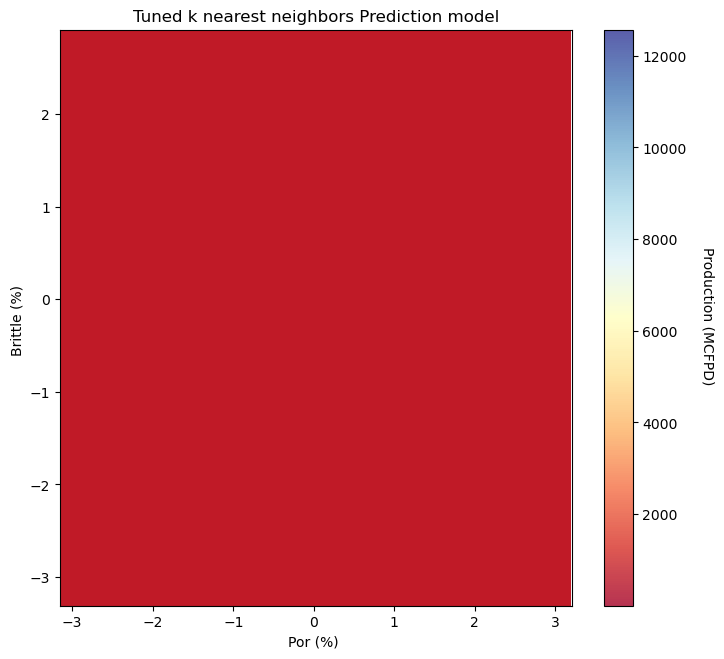

In [25]:
plt.subplot(111)
visualize_model_wrap(grid_cv_tuned_tree, ix1,ix2,iy,'Tuned k nearest neighbors Prediction model', trans=False)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.2);
plt.show()

**Retrieve the Tuned Model Hyperparameters**

In [23]:
grid_cv_tuned_tree.best_params_

{'tree__max_depth': 8, 'tree__max_leaf_nodes': 29, 'tree__min_samples_leaf': 1}